In [17]:
from sklearnex import patch_sklearn
patch_sklearn()
import warnings
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import tensorflow as tf
import tensorflow.keras.layers as layers 
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler


# tensorflow==2.6.0

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [18]:
print(tf.test.is_built_with_cuda())


True


In [19]:
# 创建映射字典
label_number = {"装": 1, "卸": -1}

# 定义一个函数，用于将Category列的文本转换为对应数值
# def label_to_number(row):
#     v = row["state"]
#     if v not in label_number:
#         return 0
#     return label_number[v]


# def number_to_label(row):
#     v = row["state"].strip()
#     display(v)
#     if v == 1:
#         return "装"
#     elif v == -1:
#         return "卸"
#     else:
#         return "-"


dfstate = pd.read_csv("./data/states.txt")
dfstate["start"] = dfstate.apply(
    lambda row: row["date"] + " " + row["start_time"], axis=1
)
dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
dfstate["label"] = dfstate.pop("state").str.strip()
# 转为时间类型
dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
# dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
# dfstate['label'] = dfstate.apply(number_to_label,axis=1)
dfstate.to_csv("./data/states.csv")
dfstate.head(), dfstate.shape

(         date start_time  end_time               start                 end  \
 0  2023-12-17   10:44:49  10:48:59 2023-12-17 10:44:49 2023-12-17 10:48:59   
 1  2023-12-17   11:29:45  11:31:55 2023-12-17 11:29:45 2023-12-17 11:31:55   
 2  2023-12-17   12:23:56  12:29:44 2023-12-17 12:23:56 2023-12-17 12:29:44   
 3  2023-12-17   12:55:08  12:56:28 2023-12-17 12:55:08 2023-12-17 12:56:28   
 4  2023-12-17   13:45:02  13:45:42 2023-12-17 13:45:02 2023-12-17 13:45:42   
 
   label  
 0     装  
 1     卸  
 2     装  
 3     卸  
 4     装  ,
 (56, 6))

In [20]:
# 定义读取，处理数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果

    inputDF.insert(0, "label", "-")

    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]

        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass

    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF


def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )


# 读取数据
df1 = read_data("./data/data_17.xlsx")
df21 = read_data("./data/data_21.xlsx")
df22 = read_data("./data/data_22.xlsx")
df23 = read_data("./data/data_23.xlsx")

# df1=pd.read_csv('data.csv')

# df1=df1.iloc[:,2:]
# df1.tail(),'rows',len(df1)

In [21]:
# df1.info()
# display(df1.shape,df21.shape,df22.shape,df23.shape)
# len(df1.query('state != 0')),len(df21.query('state != 0')),len(df22.query('state != 0')),len(df23.query('state != 0'))
# df1.head()
# display( df1.query('state != 0'),len(df21.query('state != 0')),len(df22.query('state != 0')),len(df23.query('state != 0')))
display(df1.head())
display(df1.query('label != "-"'))

,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063,2020,-4375,33161,13662,326,76328,1867,...,0,0,0,2023-12-17 09:39:28,0,0,0.0,0.0,0.0,0.0
1,-,2023-12-17 09:39:26,-4175,2020,-4364,33160,13636,327,76355,1867,...,0,0,0,2023-12-17 09:39:28,0,0,0.0,0.0,0.0,0.0
2,-,2023-12-17 09:39:30,-4575,2020,-4486,33171,13649,312,76342,1867,...,0,5,5,2023-12-17 09:39:38,0,0,0.0,0.0,0.0,0.0
3,-,2023-12-17 09:39:32,-4330,2020,-4397,33163,13649,314,76342,1867,...,0,6,6,2023-12-17 09:39:38,0,0,0.0,0.0,0.0,0.0
4,-,2023-12-17 09:39:35,-4442,2020,-4475,33170,13648,314,76343,1873,...,6,-6,-11,2023-12-17 09:39:38,0,0,0.0,0.0,0.0,0.0


,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
1251,装,2023-12-17 10:44:51,2917,0,2917,32506,12584,-3878,76807,3032,...,0,0,0,2023-12-17 10:45:00,0,0,108.825000,0.000000,0.439861,0.000000
1252,装,2023-12-17 10:44:54,3006,0,4832,32334,12565,-3495,76933,3032,...,0,-226,165,2023-12-17 10:45:00,0,0,48.216667,0.000000,-0.574931,0.000000
1253,装,2023-12-17 10:44:56,-8071,0,-5433,33256,12539,-4495,76521,3098,...,66,121,-242,2023-12-17 10:45:00,0,0,-84.608333,0.000000,-2.001667,0.000000
1254,装,2023-12-17 10:44:59,-10109,0,-8060,33492,12764,-3675,76653,2949,...,-149,-1093,940,2023-12-17 10:45:00,0,0,4.358333,0.000000,-0.379653,0.000000
1255,装,2023-12-17 10:45:03,-25818,0,-23258,34857,13436,-4805,75648,2433,...,-516,-176,483,2023-12-17 10:45:10,0,0,-189.916667,0.000000,-2.518194,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8166,卸,2023-12-17 16:57:46,36340,36940,37564,29394,13073,-118,76892,2883,...,11,17,-55,2023-12-17 16:57:51,0,36040,-5.375000,-1.583333,-0.647083,-0.871181
8167,卸,2023-12-17 16:57:50,38544,36940,39446,29225,13225,-1,76762,2889,...,6,49,-16,2023-12-17 16:57:51,0,36040,12.800000,-1.541667,-0.510347,-0.870486
8168,卸,2023-12-17 16:57:53,38511,36940,38578,29303,13286,-95,76702,2894,...,5,16,-11,2023-12-17 16:58:02,0,36040,10.208333,-1.541667,-0.548125,-0.870486
8169,卸,2023-12-17 16:57:56,36073,36940,36930,29451,13083,-245,76894,2889,...,-5,11,-17,2023-12-17 16:58:02,0,36040,-9.091667,-1.541667,-0.672708,-0.870486


In [22]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn import preprocessing

# def plot(data, title):
#     sns.set_style('dark')
#     f, ax = plt.subplots()
#     ax.set(ylabel='frequency')
#     ax.set(xlabel='height(blue) / weight(green)')
#     ax.set(title=title)
#     sns.distplot(data[:, 0:1], color='blue')
#     sns.distplot(data[:, 1:2], color='green')
#     plt.savefig(title + '.png')
#     plt.show()

# np.random.seed(42)
# height = np.random.normal(loc=168, scale=5, size=1000).reshape(-1, 1)
# weight = np.random.normal(loc=70, scale=10, size=1000).reshape(-1, 1)

# original_data = np.concatenate((height, weight), axis=1)
# plot(original_data, 'Original')

# standard_scaler_data = preprocessing.StandardScaler().fit_transform(original_data)
# plot(standard_scaler_data, 'StandardScaler')

# min_max_scaler_data = preprocessing.MinMaxScaler().fit_transform(original_data)
# plot(min_max_scaler_data, 'MinMaxScaler')

# max_abs_scaler_data = preprocessing.MaxAbsScaler().fit_transform(original_data)
# plot(max_abs_scaler_data, 'MaxAbsScaler')

# normalizer_data = preprocessing.Normalizer().fit_transform(original_data)
# plot(normalizer_data, 'Normalizer')

# robust_scaler_data = preprocessing.RobustScaler().fit_transform(original_data)
# plot(robust_scaler_data, 'RobustScaler')

In [23]:
number_types = [np.number]
label_types = ["object"]
time_types = ["datetime64[ns]"]
numeric_cols = df1.select_dtypes(include=number_types).columns.tolist()
label_cols = df1.select_dtypes(include=label_types).columns.tolist()
time_cols = df1.select_dtypes(include=time_types).columns.tolist()
# display(label_cols,time_cols,numeric_cols)

# 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
# 创建标准化器对象
scaler = MinMaxScaler()

# （label）标准化
le = LabelEncoder()
le.fit(["装", "卸", "-"])


def normalize(inpudf: pd.DataFrame) -> pd.DataFrame:
    """对df进行标准化处理"""
    inpudf = inpudf.copy()
    # 数值型数据标准化： 使用StandardScaler或者MinMaxScaler进行标准化处理。
    scaler.fit(inpudf[numeric_cols])
    inpudf[numeric_cols] = scaler.fit_transform(inpudf[numeric_cols])

    # 类别数据（label）标准化： 类别数据通常不做标准化，而是进行编码，比如One-Hot编码或者Label Encoding。
    for col in label_cols:
        inpudf[col] = le.fit_transform(inpudf[col])

    # 时间数据标准化： 时间数据通常不进行标准化，而是转换成可以比较的形式，如Unix时间戳或时间段差。
    # 将所有时间列转换为Unix时间戳（单位为秒）
    for col in time_cols:
        inpudf[col] = (
            inpudf[col].astype(np.int64) / 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf


# 反标准化


def denormalize(inpudf: pd.DataFrame) -> pd.DataFrame:
    """对df中的数值列进行反标准化处理"""

    # 数值型数据标准化-
    inpudf[numeric_cols] = scaler.inverse_transform(inpudf[numeric_cols])

    # 类别数据（label）标准化-
    for col in label_cols:
        inpudf[col] = le.inverse_transform(inpudf[col])

    # 时间数据标准化-
    for col in time_cols:
        inpudf[col] = pd.to_datetime(
            inpudf[col] * 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf


df0 = normalize(df1)

df1 = denormalize(df0)
display(df1.head())
display(df0.head())

,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063.0,2020.0,-4375.0,33161.0,13662.0,326.0,76328.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,0.0,0.0,0.0,0.0,0.0,0.0
1,-,2023-12-17 09:39:26,-4175.0,2020.0,-4364.0,33160.0,13636.0,327.0,76355.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,0.0,0.0,0.0,0.0,0.0,0.0
2,-,2023-12-17 09:39:30,-4575.0,2020.0,-4486.0,33171.0,13649.0,312.0,76342.0,1867.0,...,0.0,5.0,5.0,2023-12-17 09:39:38,0.0,0.0,0.0,0.0,0.0,0.0
3,-,2023-12-17 09:39:32,-4330.0,2020.0,-4397.0,33163.0,13649.0,314.0,76342.0,1867.0,...,0.0,6.0,6.0,2023-12-17 09:39:38,0.0,0.0,0.0,0.0,0.0,0.0
4,-,2023-12-17 09:39:35,-4442.0,2020.0,-4475.0,33170.0,13648.0,314.0,76343.0,1873.0,...,6.0,-6.0,-11.0,2023-12-17 09:39:38,0.0,0.0,0.0,0.0,0.0,0.0


,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063.0,2020.0,-4375.0,33161.0,13662.0,326.0,76328.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,0.0,0.0,0.0,0.0,0.0,0.0
1,-,2023-12-17 09:39:26,-4175.0,2020.0,-4364.0,33160.0,13636.0,327.0,76355.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,0.0,0.0,0.0,0.0,0.0,0.0
2,-,2023-12-17 09:39:30,-4575.0,2020.0,-4486.0,33171.0,13649.0,312.0,76342.0,1867.0,...,0.0,5.0,5.0,2023-12-17 09:39:38,0.0,0.0,0.0,0.0,0.0,0.0
3,-,2023-12-17 09:39:32,-4330.0,2020.0,-4397.0,33163.0,13649.0,314.0,76342.0,1867.0,...,0.0,6.0,6.0,2023-12-17 09:39:38,0.0,0.0,0.0,0.0,0.0,0.0
4,-,2023-12-17 09:39:35,-4442.0,2020.0,-4475.0,33170.0,13648.0,314.0,76343.0,1873.0,...,6.0,-6.0,-11.0,2023-12-17 09:39:38,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# 进行数据归一化
# from sklearn import preprocessing

# # 初始化 MinMaxScaler 对象
# min_max_scaler = preprocessing.MinMaxScaler()

# # df0=min_max_scaler.fit_transform(df1)
# # df = pd.DataFrame(df0, columns=df1.columns)
# # input_size=len(df.iloc[1,:])


# # 假设我们有一个DataFrame df，并且希望对其中的所有数值列进行标准化
# # 先提取出所有数值列
# numeric_features = df1.select_dtypes(include=[np.number]).columns.tolist()

# # 使用 fit() 方法计算最小值和最大值（训练集上）
# # min_max_scaler.fit(df1[numeric_features])
# df0=min_max_scaler.fit_transform(df1[numeric_features])
# # 使用 transform() 方法对数据进行标准化
# inpudf = pd.DataFrame(df0, columns=numeric_features, index=df1.index)
# input_size=len(inpudf.iloc[1,:])
# display(df1.head())
# display(inpudf.head())
# display(input_size,inpudf.shape)

In [25]:
# 设置LSTM的时间窗等参数
window = 5
lstm_units = 32
dropout = 0.01
epoch = 60

# 构建lstm输入
stock = df1
seq_len = window
amount_of_features = len(stock.columns)  # 有几列
data = stock.values  # pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1  # 序列长度
result = []
for index in range(len(data) - sequence_length):  # 循环数据长度-sequence_length次
    result.append(data[index : index + sequence_length])  # 第i行到i+sequence_length
result = np.array(result)  # 得到样本，样本形式为6天*3特征
row = round(0.9 * result.shape[0])  # 划分训练集测试集
train = result[: int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:, -1]
x_test = result[int(row) :, :-1]
y_test = result[int(row) :, -1][:, -1]
# reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

df1.values[3:5]

(14872, 5, 29) (14872,) (1652, 5, 29) (1652,)


array([['-', Timestamp('2023-12-17 09:39:32'), -4330.000000000001,
        2020.0, -4396.999999999999, 33163.0, 13649.0, 314.0, 76342.0,
        1866.9999999999984, -999.0, 87730.99999999999, 245.0000000000011,
        0.0, 89.00000000000429, -8.000000000000163, 0.0,
        1.9999999999995701, 0.0, 0.0, 6.00000000000008,
        5.999999999999312, Timestamp('2023-12-17 09:39:38'), 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0],
       ['-', Timestamp('2023-12-17 09:39:35'), -4441.999999999998,
        2020.0, -4474.999999999999, 33170.0, 13648.0, 314.0, 76343.0,
        1873.0000000000002, -1005.0000000000003, 87720.00000000001,
        -112.00000000000266, 0.0, -77.9999999999991, 7.00000000000054,
        -0.9999999999999281, 0.0, 1.0000000000006422, 6.000000000001183,
        -6.00000000000008, -10.999999999997415,
        Timestamp('2023-12-17 09:39:38'), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
      dtype=object)

In [26]:
# 建立LSTM模型 训练
input_size = amount_of_features
inputs = Input(shape=(window, input_size))
model = Conv1D(filters=lstm_units, kernel_size=1, activation="sigmoid")(
    inputs
)  # 卷积层
model = MaxPooling1D(pool_size=window)(model)  # 池化层
model = Dropout(dropout)(model)  # droupout层
model = Bidirectional(LSTM(lstm_units, activation="tanh"), name="bilstm")(
    model
)  # 双向LSTM层
attention = Dense(lstm_units * 2, activation="sigmoid", name="attention_vec")(
    model
)  # 求解Attention权重
model = Multiply()([model, attention])  # attention与LSTM对应数值相乘
outputs = Dense(1, activation="tanh")(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.summary()  # 展示模型结构

print([inputs.shape])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 29)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 32)        960         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1, 32)        0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 1, 32)        0           ['max_pooling1d[0][0]']          
                                                                                              

In [30]:
display(x_train)

array([[['-', Timestamp('2023-12-17 09:39:23'), -4063.0000000000014,
         ..., 0.0, 0.0, 0.0],
        ['-', Timestamp('2023-12-17 09:39:26'), -4174.999999999999, ...,
         0.0, 0.0, 0.0],
        ['-', Timestamp('2023-12-17 09:39:30'), -4574.999999999999, ...,
         0.0, 0.0, 0.0],
        ['-', Timestamp('2023-12-17 09:39:32'), -4330.000000000001, ...,
         0.0, 0.0, 0.0],
        ['-', Timestamp('2023-12-17 09:39:35'), -4441.999999999998, ...,
         0.0, 0.0, 0.0]],

       [['-', Timestamp('2023-12-17 09:39:26'), -4174.999999999999, ...,
         0.0, 0.0, 0.0],
        ['-', Timestamp('2023-12-17 09:39:30'), -4574.999999999999, ...,
         0.0, 0.0, 0.0],
        ['-', Timestamp('2023-12-17 09:39:32'), -4330.000000000001, ...,
         0.0, 0.0, 0.0],
        ['-', Timestamp('2023-12-17 09:39:35'), -4441.999999999998, ...,
         0.0, 0.0, 0.0],
        ['-', Timestamp('2023-12-17 09:39:38'), -4843.000000000002, ...,
         0.0, 0.0, 0.0]],

       [['-', T

In [28]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=amount_of_features,
    shuffle=False,
    validation_data=(X_test, y_test),
)  # 训练模型epoch次

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

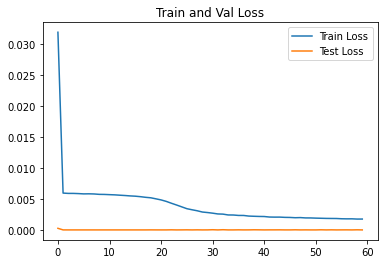

In [ ]:
# 迭代图像
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Test Loss")
plt.legend(loc="upper right")
plt.title("Train and Val Loss")
plt.show()

Text(0.5, 1.0, 'Train Data')

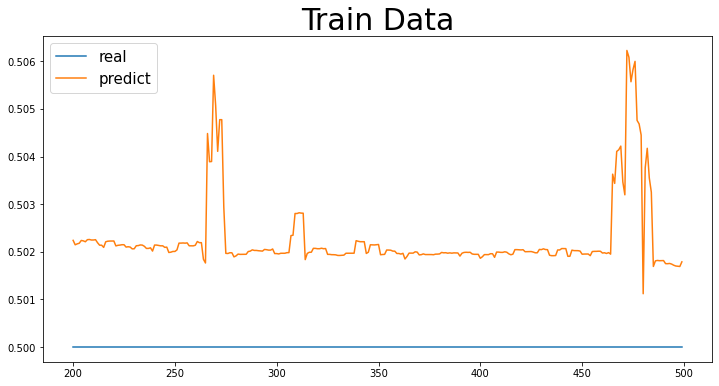

In [ ]:
# 在训练集上的拟合结果
y_train_predict = model.predict(X_train)
y_train_predict = y_train_predict[:, 0]
draw = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_train_predict)], axis=1)
draw.iloc[200:500, 0].plot(figsize=(12, 6))
draw.iloc[200:500, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Train Data", fontsize="30")  # 添加标题

Text(0.5, 1.0, 'Test Data')

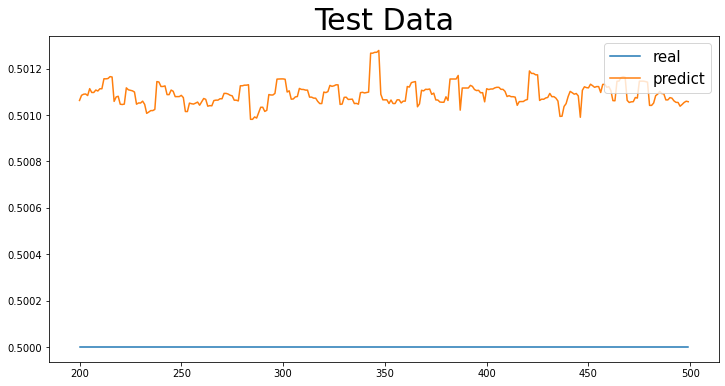

In [ ]:
# 在测试集上的预测
y_test_predict = model.predict(X_test)
y_test_predict = y_test_predict[:, 0]
draw = pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_test_predict)], axis=1)
draw.iloc[200:500, 0].plot(figsize=(12, 6))
draw.iloc[200:500, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), loc="upper right", fontsize="15")
plt.title("Test Data", fontsize="30")  # 添加标题

In [ ]:
# 输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def up_down_accuracy(y_true, y_pred):
    y_var_test = y_true[1:] - y_true[: len(y_true) - 1]  # 实际涨跌
    y_var_predict = y_pred[1:] - y_pred[: len(y_pred) - 1]  # 原始涨跌
    txt = np.zeros(len(y_var_test))
    for i in range(len(y_var_test - 1)):  # 计算数量
        txt[i] = np.sign(y_var_test[i]) == np.sign(y_var_predict[i])
    result = sum(txt) / len(txt)
    return result


print("训练集上的MAE/MSE/MAPE/涨跌准确率")
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train))
print(mape(y_train_predict, y_train))
print(up_down_accuracy(y_train_predict, y_train))
print("测试集上的MAE/MSE/MAPE/涨跌准确率")
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test))
print(mape(y_test_predict, y_test))
print(up_down_accuracy(y_test_predict, y_test))

训练集上的MAE/MSE/MAPE/涨跌准确率
0.011375044148787577
0.0012382167714091717
2.665366011134947
0.11949431779974447
测试集上的MAE/MSE/MAPE/涨跌准确率
0.00108934422959427
1.1893327229212223e-06
0.21739415172113158
0.12780133252574197
